In [1]:
import jax
import jax.numpy as jnp
from flax import nnx

MLP definition

In [2]:
class MLP(nnx.Module):
    ''' a 2 layer MLP, very simple -- only contains two linear layers
        and an activation function
        
        network looks like: din --> dhidden --> dout
    '''
    def __init__(self, 
                 din: int, 
                 dhidden: int, 
                 dout: int, 
                 *, 
                 rngs: nnx.Rngs):
        
        self.layer1 = nnx.Linear(din, dhidden, rngs=rngs)
        self.layer2 = nnx.Linear(dhidden, dout, rngs=rngs)

    def __call__(self, x):
        # Pass x through layer 1, followed by activation, then layer 2
        return self.layer2(jax.nn.relu(self.layer1(x)))

Let's define the data that we want the model to learn. It will be a linear function that is perturbed by some randomness. So it will have one feature dimension,

In [3]:
X = jnp.linspace(0, 1, 100)[:, None] # reshape into correct dimensions: (100, 1)
Y = 2 * X + 1 + jax.random.uniform(jax.random.key(42), (100, 1)) # (100, 1)

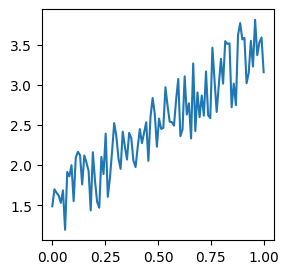

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.plot(X, Y)

Define the random number generator

In [5]:
rngs = nnx.Rngs(params=0)

Define the model

In [6]:
model = MLP(din=1,
            dhidden=10,
            dout=1,
            rngs=rngs)

Now let's train!

In [7]:
import optax
optimizer = nnx.Optimizer(model, optax.sgd(learning_rate=0.1))

@nnx.jit
def train_step(model, optimizer, x, y):
    ''' A single training step for the model '''
    def compute_loss(model):
        # get the loss for where the model is currently at
        y_pred = model(x)
        
        # compute the loss -- mean squared error in this case
        return jnp.mean((y - y_pred)**2)
    
    # compute loss and gradients
    loss, grads = nnx.value_and_grad(compute_loss)(model)
    
    # update the gradients using our optimizer via backprop
    optimizer.update(grads)
    
    # report our loss back to our training steps
    return loss

And now let's train our model

In [8]:
print(f'Initial loss: {train_step(model, optimizer, X, Y)}')

for step in range(100):
    loss = train_step(model, optimizer, X, Y)
    if step % 10 == 0:
        print(f'Step {step} loss: {loss:.2f}')

Initial loss: 4.765919208526611
Step 0 loss: 0.90
Step 10 loss: 0.10
Step 20 loss: 0.08
Step 30 loss: 0.08
Step 40 loss: 0.07
Step 50 loss: 0.07
Step 60 loss: 0.07
Step 70 loss: 0.07
Step 80 loss: 0.07
Step 90 loss: 0.07


What did the model learn as the weights and biases? We can take a look inside the MLP:

In [9]:
print(model)

MLP( # Param: 31 (124 B)
  layer1=Linear( # Param: 20 (80 B)
    bias=Param( # 10 (40 B)
      value=Array(shape=(10,), dtype=dtype('float32'))
    ),
    bias_init=<function zeros at 0x71c4ba5843a0>,
    dot_general=<function dot_general at 0x71c4cebb5bd0>,
    dtype=None,
    in_features=1,
    kernel=Param( # 10 (40 B)
      value=Array(shape=(1, 10), dtype=dtype('float32'))
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x71c4b9aa15a0>,
    out_features=10,
    param_dtype=float32,
    precision=None,
    promote_dtype=<function promote_dtype at 0x71c4b9aa1510>,
    use_bias=True
  ),
  layer2=Linear( # Param: 11 (44 B)
    bias=Param( # 1 (4 B)
      value=Array([0.9011996], dtype=float32)
    ),
    bias_init=<function zeros at 0x71c4ba5843a0>,
    dot_general=<function dot_general at 0x71c4cebb5bd0>,
    dtype=None,
    in_features=10,
    kernel=Param( # 10 (40 B)
      value=Array(shape=(10, 1), dtype=dtype('float32'))
    ),
    kernel_init=<function varia

Common language for the weights are the "kernel" which comes from the naming convention that stems from CNNs---there, it's a small window that slides "filters" the image/data in order to detect features. Since weights are being used to detect features, we name it a kernel as well in order to keep the naming convention more general for different architectures

In [10]:
print(model.layer2.kernel) # this is the weight matrix corresponding to layer 2

Param( # 10 (40 B)
  value=Array([[ 0.7553346 ],
         [ 0.44777507],
         [-0.14019461],
         [-0.26228175],
         [ 0.13043015],
         [ 0.12866093],
         [ 0.3996193 ],
         [-0.25609112],
         [ 0.42099538],
         [-0.4868177 ]], dtype=float32)
)


These look messy because it's an MLP, and we're not learning coefficients for linear regression or something like that

In [11]:
print(model.layer2.bias) # this is the value of the bias coefficient, which is almost 1

Param( # 1 (4 B)
  value=Array([0.9011996], dtype=float32)
)


We can plot the predictions of the model and compare it to the true data distribution

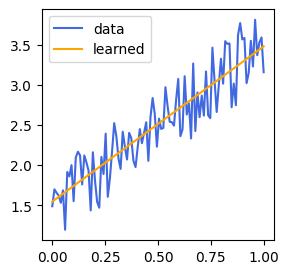

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.plot(X, Y, color='royalblue', label='data')
axs.plot(X, model(X), color='orange', label='learned')
axs.legend()

Now say that we want this simple MLP to also be able to model a parabolic function. To do this we just need to "finetune" our model "post the original training" in order for it to match the new function

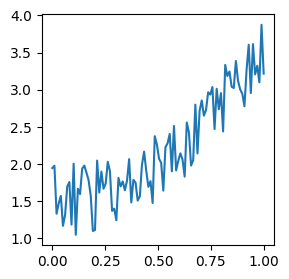

In [15]:
X = jnp.linspace(0, 1, 100)[:, None]
Ypara = 2*X**2 + 1 + jax.random.uniform(jax.random.key(0), shape=(100,1))

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.plot(X, Ypara)

In [16]:
for step in range(100):
    # fine tune the model on this data set as well
    loss = train_step(model, optimizer, X, Ypara)
    if step % 10 == 0:
        print(f'Step {step} loss: {loss}')

Step 0 loss: 0.20570489764213562
Step 10 loss: 0.11366172879934311
Step 20 loss: 0.11140327900648117
Step 30 loss: 0.11033737659454346
Step 40 loss: 0.10984769463539124
Step 50 loss: 0.10962704569101334
Step 60 loss: 0.10952892154455185
Step 70 loss: 0.10948570817708969
Step 80 loss: 0.1094667911529541
Step 90 loss: 0.10945852100849152


and let's see how it does now!

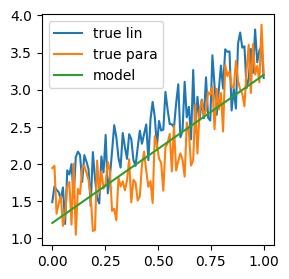

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.plot(X, Y, label='true lin')
axs.plot(X, Ypara, label='true para')
axs.plot(X, model(X), label='model')
axs.legend()

so it kind of meets them both in the middle, which is what we expect if we're going to be training the model with an equal number of steps for either function